# Location, Location, Location?

*Machine Learning regression using the Ames Housing dataset.*

This post introduces Machine Learning regression. Regression is the prediction of a quantity/number, in contrast with classification where a class is predicted. We will use the Ames Housing Dataset compiled by Dean De Cock to predict the sale price of houses in Ames, Iowa.

In this post, you'll learn how to:
- present data using the Seaborn data visualisation package;
- train and evaluate a regression model; and
- combine multiple models for a better result.

By the end, you'll learn how to predict the sale price of all 1,459 houses in `test.csv`. Here are a preview of the first 5 houses:

In [11]:
df = pd.read_csv('data/house_prices/test.csv', index_col='Id')
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


This [notebook is available on GitHub](https://github.com/ActaMachina/notebooks/blob/master/03-house-prices.ipynb) and the [data is hosted on Amazon CloudFront](/data/03-house-prices.zip).

## Preamble

In [2]:
from IPython.display import Image
from matplotlib import lines

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

## Import Packages

We'll be importing the same packages as the previous post, namely `scipy`, `sklearn` and `pandas`. We'll also include the data visualisation library `seaborn` since it contains some useful plots.

In [4]:
from scipy.special import boxcox1p, inv_boxcox
from scipy.stats import skew

from pandas.api.types import CategoricalDtype

from sklearn.base import clone, BaseEstimator, RegressorMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import Lasso, Ridge

import pandas as pd
import seaborn as sns

## Load Data

Let's load the training data in `train.csv` into a Pandas DataFrame with `Id` as index.

Unlike the previous post, where we only had one row to predict, we wish to predict all 1,459 rows inside `test.csv`.  So, load the training and test data from two separate files into two DataFrames: `df_train` (1,460 rows) and `df_test` (1,459 rows). Any analysis and insights should only be obtained from the `df_train` and not be informed by `df_test`.

In [12]:
df_train = pd.read_csv('data/house_prices/train.csv', index_col='Id')
df_test = pd.read_csv('data/house_prices/test.csv', index_col='Id')

df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


The DataFrame has 80 columns:

In [13]:
df_train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Columns: 80 entries, MSSubClass to SalePrice
dtypes: float64(3), int64(34), object(43)
memory usage: 923.9+ KB


Some of the features include `SalePrice`, `MSSubClass`, `MSZoning` and `LotFrontage`:

| Feature  | Description |
| -------- | ----------- |
| SalePrice | Property's Sale Price in Dollars |
| MSSubClass | Building Class |
| MSZoning | General Zoning Classification |
| LotFrontage | Linear Feet of Street Connected to Property |
| ... | ... |

The data visualisation library, Seaborn, has lots of interesting plots like Hexbin, Kernel Density Estimate (KDE) and Violin plots.

This Heatmap plot shows the relationships of the 7 features most correlated with `SalePrice`: 

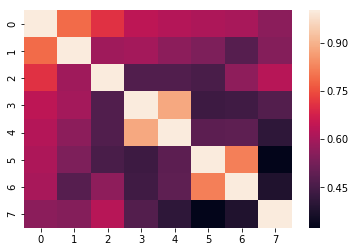

In [14]:
k = 8  # number of features for heatmap

correlation_matrix = df_train.corr()
columns = correlation_matrix.nlargest(k, 'SalePrice').SalePrice.index

covariance_matrix = np.corrcoef(df_train[columns].values.T)
sns.heatmap(covariance_matrix)

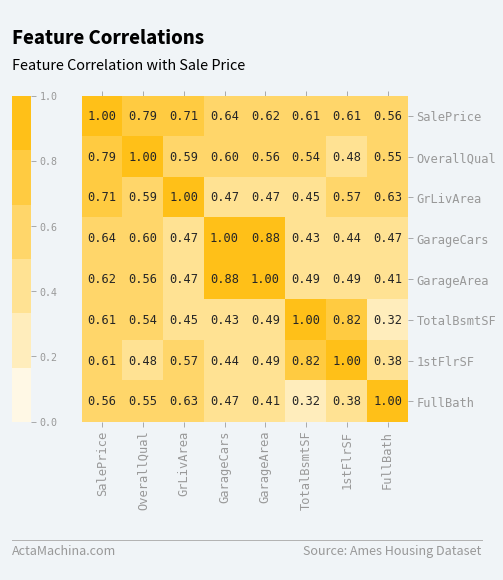

In [15]:
k = 8  # number of features for heatmap
correlation_matrix = df_train.corr()
grid_kws = {'width_ratios': (.04, .9), 'wspace': 0}

with plt.style.context(('plot.mplstyle')):
    fig, (cbar_ax, ax) = plt.subplots(figsize=(8, 6), ncols=2, gridspec_kw=grid_kws)
    
    columns = correlation_matrix.nlargest(k, 'SalePrice').SalePrice.index
    covariance_matrix = np.corrcoef(df_train[columns].values.T)
    heatmap = sns.heatmap(
        covariance_matrix,
        cbar=True,
        annot=True,
        square=True,
        fmt='.2f',
        annot_kws={'size': 12},
        vmin=0.0,
        vmax=1.0,
        yticklabels=columns.values,
        xticklabels=columns.values,
        cmap=sns.light_palette("#ffc018", input="hex"),
        ax=ax,
        cbar_ax=cbar_ax,
    );

    plt.text(0.125, 1, '\n' + 'Feature Correlations', family='Source Sans Pro', fontsize=21, fontweight='bold', transform=plt.gcf().transFigure)
    plt.text(0.125, 0.94, 'Feature Correlation with Sale Price', family='Source Sans Pro', fontsize=16, transform=plt.gcf().transFigure)
    plt.tick_params(labelsize=12)
    ax.yaxis.tick_right()
    
    for tick in ax.get_yticklabels():
        tick.set_rotation(0)

    # footer
    ax.add_line(lines.Line2D([0.125, 0.94], [-0.15, -0.15], linewidth=1, color='0.7', clip_on=False, transform=fig.transFigure))
    plt.text(0.125, -0.16, 'ActaMachina.com' + '\n', color='0.6', family='Source Sans Pro', fontsize=14, horizontalalignment='left', verticalalignment='top', transform=plt.gcf().transFigure)
    plt.text(0.94, -0.16, 'Source: Ames Housing Dataset' + '\n', color='0.6', family='Source Sans Pro', fontsize=14, horizontalalignment='right', verticalalignment='top', transform=plt.gcf().transFigure)

From the Heatmap, you can see that the top 7 features most highly correlated with `SalePrice` are:
1. `OverallQual`: overall material and finish quality;
2. `GrLivArea`: above grade (ground) living area, in square feet;
3. `GarageCars`: size of garage, in car capacity;
4. `GarageArea`: size of garage, in square feet;
5. `TotalBsmtSF`: total square feet of basement area;
6. `1stFlrSF`: size of first floor, in square feet; and
7. `FullBath`: full bathrooms, above grade.

## Data Pre-processing

The data pre-processing steps here are similar to the ones in the previous post. We want to:
- convert all columns to their correct data types, removing columns of `object` data type;
- impute (meaningfully fill in) or remove missing data;
- one-hot encode categories; and
- fix skewness for numerical features.

### Convert Columns to Correct Data Types

Columns of `object` data type are either actual strings or categories in the form of strings. 

Let's check all the columns of `object` data type and see how many unique values they contain:

In [16]:
df_train.select_dtypes(include='object').nunique().sort_values(ascending=False)

Neighborhood     25
Exterior2nd      16
Exterior1st      15
Condition1        9
SaleType          9
Condition2        8
HouseStyle        8
RoofMatl          8
Functional        7
SaleCondition     6
BsmtFinType2      6
Heating           6
Foundation        6
GarageType        6
RoofStyle         6
BsmtFinType1      6
ExterCond         5
BldgType          5
LotConfig         5
MSZoning          5
GarageCond        5
GarageQual        5
HeatingQC         5
Electrical        5
FireplaceQu       5
LotShape          4
LandContour       4
MiscFeature       4
Fence             4
BsmtExposure      4
BsmtCond          4
KitchenQual       4
MasVnrType        4
ExterQual         4
BsmtQual          4
GarageFinish      3
PavedDrive        3
PoolQC            3
LandSlope         3
Utilities         2
CentralAir        2
Alley             2
Street            2
dtype: int64

Since `df_train` has a total of 1,460 rows, we can assume that even the column with 25 unique values is a category column. So, we convert all columns of `object` data type into `category`:

In [17]:
object_columns = df_train.select_dtypes(include='object').columns

for object_column in object_columns:
    # ensure same categories across df_train and df_test
    categories = set(pd.concat([df_train[object_column], df_test[object_column]]).dropna())
    
    df_train[object_column] = df_train[object_column].astype(CategoricalDtype(categories=categories))
    df_test[object_column] = df_test[object_column].astype(CategoricalDtype(categories=categories))

### Impute/Remove Missing Data

Let's create a missing data row count for each feature:

In [18]:
missing_data = pd.DataFrame({'Count': df_train.isnull().sum(),
                             'MissingPercentage': df_train.isnull().sum() / df_train.isnull().count() * 100})

missing_data[missing_data.Count > 0].sort_values(by='Count', ascending=False)

,Count,MissingPercentage
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945
GarageQual,81,5.547945


We can remove features with missing data in more than 1% of its rows. Since we can't have any missing values after this step, if we don't remove the feature, we must remove the entire row instead. The key is to strike a balance between removing too many features and removing too many rows. The 1% figure is arbitrary but seems to be a good balance from observing the data.

In [19]:
columns_to_remove = list(missing_data[missing_data.MissingPercentage > 1].index)
df_train.drop(columns_to_remove, axis=1, inplace=True)
df_test.drop(columns_to_remove, axis=1, inplace=True)

Now, we delete the remaining rows that contain missing values:

In [20]:
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

### One-Hot Encoding

In [21]:
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

### Fix Skewness for Numerical Features

Although we briefly covered the need to fix skewness for numerical features in the previous post, let's use Seaborn to plot the target feature, `SalePrice` as a distribution plot:

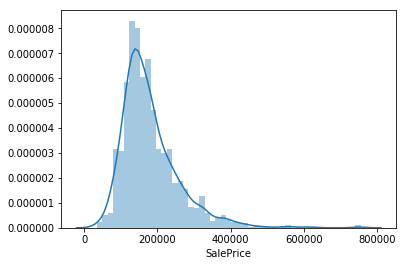

In [22]:
sns.distplot(df_train.SalePrice);

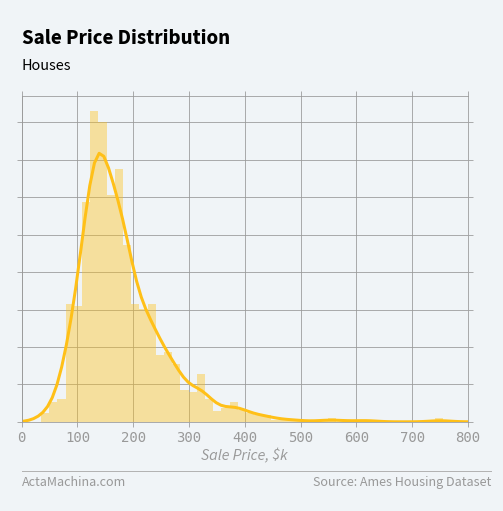

In [23]:
with plt.style.context(('plot.mplstyle')):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.distplot(
        df_train.SalePrice/1000,
        color='#ffc018',
        kde_kws={'linewidth': 3},
    )
    
    plt.text(0.125, 1, '\n' + 'Sale Price Distribution', family='Source Sans Pro', fontsize=21, fontweight='bold', transform=plt.gcf().transFigure)
    plt.text(0.125, 0.94, 'Houses', family='Source Sans Pro', fontsize=16, transform=plt.gcf().transFigure)
    plt.text(0.95, 0.5, '\n', transform=plt.gcf().transFigure)
    plt.text(0.1, 0.5, '\n', transform=plt.gcf().transFigure)
    plt.xlabel('' + 'Sale Price, $k' + '\n\n', color='0.6', family='Source Sans Pro', fontsize=16, fontstyle='italic')
    plt.tick_params(labelsize=14)
    ax.set_xlim(0, 800)
    ax.set_yticklabels([])

    # footer
    ax.add_line(lines.Line2D([0.125, 0.94], [0.01, 0.01], linewidth=1, color='0.7', clip_on=False, transform=fig.transFigure))
    plt.text(0.125, 0, 'ActaMachina.com' + '\n', color='0.6', family='Source Sans Pro', fontsize=14, horizontalalignment='left', verticalalignment='top', transform=plt.gcf().transFigure)
    plt.text(0.94, 0, 'Source: Ames Housing Dataset' + '\n', color='0.6', family='Source Sans Pro', fontsize=14, horizontalalignment='right', verticalalignment='top', transform=plt.gcf().transFigure)

Now, we apply Box Cox transform to the features with skew > 0.75:

In [24]:
lambda_ = 0.15

skewness = pd.DataFrame({'Skew': df_train.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)})
skewed_columns = skewness[abs(skewness) > 0.75].dropna().index

print(f"There are {skewed_columns.shape[0]} skewed features to Box Cox transform.")

for column in skewed_columns:
    df_train[column] = boxcox1p(df_train[column], lambda_)

    if column != 'SalePrice':
        df_test[column] = boxcox1p(df_test[column], lambda_)

There are 199 skewed features to Box Cox transform.


Let's look at a distribution plot of `SalePrice` again after skew correction: 

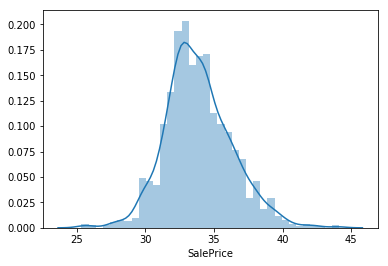

In [25]:
sns.distplot(df_train.SalePrice);

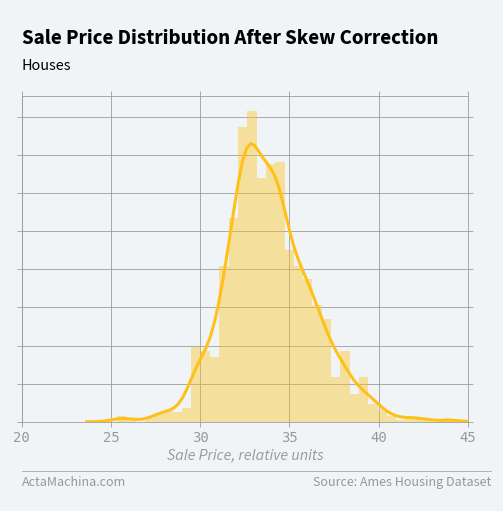

In [26]:
with plt.style.context(('plot.mplstyle')):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.distplot(
        df_train.SalePrice,
        color='#ffc018',
        kde_kws={'linewidth': 3},
    )
    
    plt.text(0.125, 1, '\n' + 'Sale Price Distribution After Skew Correction', family='Source Sans Pro', fontsize=21, fontweight='bold', transform=plt.gcf().transFigure)
    plt.text(0.125, 0.94, 'Houses', family='Source Sans Pro', fontsize=16, transform=plt.gcf().transFigure)
    plt.text(0.95, 0.5, '\n', transform=plt.gcf().transFigure)
    plt.text(0.1, 0.5, '\n', transform=plt.gcf().transFigure)
    plt.xlabel('' + 'Sale Price, relative units' + '\n\n', color='0.6', family='Source Sans Pro', fontsize=16, fontstyle='italic')
    plt.tick_params(labelsize=14)
    ax.set_xlim(20, 45)
    ax.set_yticklabels([])

    # footer
    ax.add_line(lines.Line2D([0.125, 0.94], [0.01, 0.01], linewidth=1, color='0.7', clip_on=False, transform=fig.transFigure))
    plt.text(0.125, 0, 'ActaMachina.com' + '\n', color='0.6', family='Source Sans Pro', fontsize=14, horizontalalignment='left', verticalalignment='top', transform=plt.gcf().transFigure)
    plt.text(0.94, 0, 'Source: Ames Housing Dataset' + '\n', color='0.6', family='Source Sans Pro', fontsize=14, horizontalalignment='right', verticalalignment='top', transform=plt.gcf().transFigure)

Now the features are ready for the machine learning regression model!

## Model

To prepare the data for the models, we separate the features (X) from the target label (y):

In [27]:
X = df_train.drop('SalePrice', axis=1)
y = df_train.SalePrice.values.ravel()

First, we'll go through a simple regression model that is similar to the classification model in the previous post. Then, we'll delve into a more complicated ensemble model.

### Simple Model

In the previous post, we used `train_test_split` to split `X` and `y` into a train/test set before fitting and scoring the model. We can get a more reliable score by using the `cross_val_score` function to do this multiple times (on a different train/test split each time) and take the average. This is called $k$-fold cross-validation, where $k$ is the number of train/test splits. The value of $k$ can range from 2 (a single train/test split) to $N$, the total number of rows in the data set. The extreme case where $k = N$ is also called leave-one-out cross-validation.

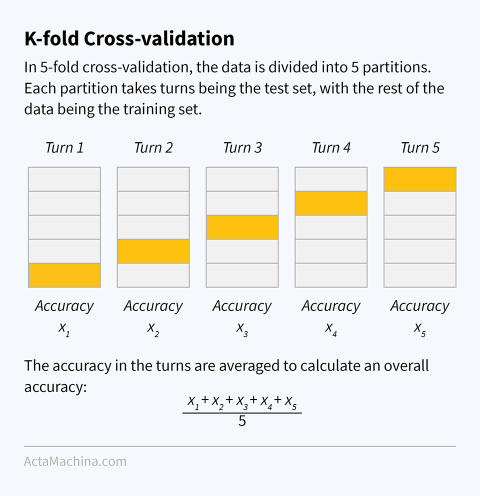

In [28]:
Image('figures/03-k-fold-cross-validation.png')

Here, we use the 5-fold cross-validation (where $k = 5$) to evaluate the model:

In [29]:
model = RandomForestRegressor()
scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print('Score: {:.5f} ({:.5f})'.format(scores.mean(), scores.std()))

Score: 0.85688 (0.02040)


Now let's train the model using all of `X` and `y` and then use the trained model to make predictions on `df_test`:

In [30]:
model = RandomForestRegressor()
model.fit(X, y)
pred = model.predict(df_test)
pred

array([32.0262467 , 32.96734321, 33.97662815, ..., 33.25564396,
       31.821167  , 35.92025014])

Wait, these predicted sale prices don't look quite right. Since we applied Box-Cox transform to help reshape `SalePrice`, we need to undo it by calling `inv_boxcox`:

In [31]:
inv_boxcox(pred, lambda_)

array([123448.15398991, 144897.80806527, 171343.55636578, ...,
       152070.92600908, 119151.13227291, 233946.41203722])

In [32]:
pd.read_csv('data/house_prices/test.csv', index_col='Id').head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


So, the first 5 houses of `df_test` (above) have predicted `SalePrice` of: 

In [33]:
inv_boxcox(pred[:5], lambda_)

array([123448.15398991, 144897.80806527, 171343.55636578, 186487.2081506 ,
       206409.9966901 ])

### Ensemble Model

An ensemble model is one that combines the strengths of several simpler base models. There are three common types of ensemble models:
- **boosting:** uses multiple, identical models that are trained in sequence, with each subsequent model trained  emphasising the mis-classifications of the previous model;
- **bootstrap aggregation (or bagging):** uses multiple, identical models that are trained on randomly drawn subsets of the training set; and
- **stacking:** uses different models to train the data.

Actually, the `RandomForestClassifier` and `RandomForestRegressor` which you've already been using are also ensemble models since they combine multiple decision trees using majority voting, with each decision tree generated using a random subset of features.

Here is an example of stacking. We create an instance of a `StackedRegressor` that combines the `Lasso`, `RandomForestRegressor` and `Ridge` regression models for a better prediction:

In [34]:
class StackedRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, models):
        self.models = models

    def fit(self, X, y):
        self.models_ = [clone(model) for model in self.models]

        for model in self.models_:
            model.fit(X, y)

        return self

    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=1)
    
stacked_model = StackedRegressor([
    Lasso(),
    RandomForestRegressor(),
    Ridge(),
])

scores = cross_val_score(stacked_model, X, y, cv=5, scoring='r2')
print('Score: {:.5f} ({:.5f})'.format(scores.mean(), scores.std()))

Score: 0.86763 (0.02538)


We see that the `StackedRegressor` (86.763%) performed better than the `RandomForestRegressor` by itself (85.688%).

## Summary and Next Steps

In this post, you've learnt how to:
- present data using the Seaborn data visualisation package;
- train and evaluate a regression model; and
- combine multiple models for a better result.

Now you're familar with both types of Supervised Learning: classification (predicting a class) and regression (predicting a quantity). There are two other broad types of Machine Learning: (i) Unsupervised Learning is when you are only given inputs and tasked to find interesting attributes of the dataset, such as clusters or outliers; and (ii) Reinforcement Learning is where an agent interacts with an environment and changes its action based on rewards. These will be explored in future posts. Stay tuned!

## Acknowledgements

This post has been inspired by posts from:

- [Kaggle House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)
- [Comprehensive Data Exploration with Python by Pedro Marcelino](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python)
- [Stacked Regressions: Top 4% on LeaderBoard by Serigne](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard)

## Notes

| Feature  | Description |
| -------- | ----------- |
| SalePrice | The property's sale price in dollars. |
| MSSubClass | The building class. |
| MSZoning | The general zoning classification. |
| LotFrontage | Linear feet of street connected to property. |
| LotArea | Lot size in square feet. |
| Street | Type of road access. |
| Alley | Type of alley access. |
| LotShape | General shape of property. |
| LandContour | Flatness of the property. |
| Utilities | Type of utilities available. |
| LotConfig | Lot configuration. |
| LandSlope | Slope of property. |
| Neighborhood | Physical locations within Ames city limits. |
| Condition1 | Proximity to main road or railroad. |
| Condition2 | Proximity to main road or railroad (if a second is present). |
| BldgType | Type of dwelling. |
| HouseStyle | Style of dwelling. |
| OverallQual | Overall material and finish quality. |
| OverallCond | Overall condition rating. |
| YearBuilt | Original construction date. |
| YearRemodAdd | Remodel date. |
| RoofStyle | Type of roof. |
| RoofMatl | Roof material. |
| Exterior1st | Exterior covering on house. |
| Exterior2nd | Exterior covering on house (if more than one material). |
| MasVnrType | Masonry veneer type. |
| MasVnrArea | Masonry veneer area in square feet. |
| ExterQual | Exterior material quality. |
| ExterCond | Present condition of the material on the exterior. |
| Foundation | Type of foundation. |
| BsmtQual | Height of the basement. |
| BsmtCond | General condition of the basement. |
| BsmtExposure | Walkout or garden level basement walls. |
| BsmtFinType1 | Quality of basement finished area. |
| BsmtFinSF1 | Type 1 finished square feet. |
| BsmtFinType2 | Quality of second finished area (if present). |
| BsmtFinSF2 | Type 2 finished square feet. |
| BsmtUnfSF | Unfinished square feet of basement area. |
| TotalBsmtSF | Total square feet of basement area. |
| Heating | Type of heating. |
| HeatingQC | Heating quality and condition. |
| CentralAir | Central air conditioning. |
| Electrical | Electrical system. |
| 1stFlrSF | First Floor square feet. |
| 2ndFlrSF | Second floor square feet. |
| LowQualFinSF | Low quality finished square feet (all floors). |
| GrLivArea | Above grade (ground) living area square feet. |
| BsmtFullBath | Basement full bathrooms. |
| BsmtHalfBath | Basement half bathrooms. |
| FullBath | Full bathrooms above grade. |
| HalfBath | Half baths above grade. |
| Bedroom | Number of bedrooms above basement level. |
| Kitchen | Number of kitchens. |
| KitchenQual | Kitchen quality. |
| TotRmsAbvGrd | Total rooms above grade (does not include bathrooms). |
| Functional | Home functionality rating. |
| Fireplaces | Number of fireplaces. |
| FireplaceQu | Fireplace quality. |
| GarageType | Garage location. |
| GarageYrBlt | Year garage was built. |
| GarageFinish | Interior finish of the garage. |
| GarageCars | Size of garage in car capacity. |
| GarageArea | Size of garage in square feet. |
| GarageQual | Garage quality. |
| GarageCond | Garage condition. |
| PavedDrive | Paved driveway. |
| WoodDeckSF | Wood deck area in square feet. |
| OpenPorchSF | Open porch area in square feet. |
| EnclosedPorch | Enclosed porch area in square feet. |
| 3SsnPorch | Three season porch area in square feet. |
| ScreenPorch | Screen porch area in square feet. |
| PoolArea | Pool area in square feet. |
| PoolQC | Pool quality. |
| Fence | Fence quality. |
| MiscFeature | Miscellaneous feature not covered in other categories. |
| MiscVal | $Value of miscellaneous feature. |
| MoSold | Month Sold. |
| YrSold | Year Sold. |
| SaleType | Type of sale. |
| SaleCondition | Condition of sale. |